# BERT Document Classification

This notebook uses `BERT` (Bidirectional Encoding Representations from Transformers) to train a classifier on the `Wikipeida Offensive Language` dataset. The input is the pre-trained `BERT` model, and the wikipedia dataset. The output is a classification target of whether the text is a personal attack or not. 

### Wikipedia Personal Attack / Offensive Language `Classification`

The dataset includes over 100k labeled discussion comments from English Wikipedia. Each comment was labeled by multiple annotators via Crowdflower on whether it contains a personal attack. There also contains demographic data for each crowd-worker.

* `attack_annotated_comments.tsv` contains the comment text and some properties.
* `attack_annotations.tsv` contains the labels (whether the comment contains an attack).

### Illustration of BERT Transfer Learning 
* The two steps of how BERT is developed ([Source: Jay Allamar](http://jalammar.github.io/illustrated-bert/))

![BERT Transfer Learning](http://jalammar.github.io/images/bert-transfer-learning.png)  
  




#### Set up Environment
___

```
> conda create -n BERT python=3.7 nb_conda_kernels pandas matplotlib seaborn
> conda activate BERT
> conda install tensorflow-gpu=1.15

# for CUDA 10.2 ($nvcc --version)
> pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
> pip install transformers scikit-learn keras tqdm ipywidgets
> pip install -U jupyter
```
___

Continue with imports:

In [1]:
import urllib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
import torch
import transformers
from transformers import BertTokenizer

torch.cuda.device(0)
print(torch.cuda.get_device_name(0))
print(f'Pytorch {torch.__version__}\nHuggingFace transformers {transformers.__version__}')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

GeForce RTX 2070
Pytorch 1.4.0
HuggingFace transformers 2.4.1


In [2]:
# Tensorflow GPU Check
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
print(f'tensorflow {tf.__version__}')

Found GPU at: /device:GPU:0
tensorflow 1.15.0


In [3]:
# Pytorch GPU Check
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070


# 1. Wikipedia Personal Attacks
#### 1.1 Download dataset

In [4]:
%%time
if not os.path.exists('./data/'): os.mkdir('./data/')

files = [('./data/attack_annotated_comments.tsv', 
          'https://ndownloader.figshare.com/files/7554634'),
         ('./data/attack_annotations.tsv', 
          'https://ndownloader.figshare.com/files/7554637')]    
    
for (filename, url) in files:
    if not os.path.exists(filename):
        print('Downloading', filename)
        urllib.request.urlretrieve(url, filename)

Wall time: 995 µs


In [5]:
comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('./data/attack_annotations.tsv', sep = '\t')

print(comments.shape)
comments.head()

(115864, 6)


,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


Dataset comes pre-split into `dev / test / train`

In [6]:
comments[['comment', 'split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [7]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [8]:
# Label a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

# Join labels and comments
comments['attack'] = labels

# Remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

comments[comments.attack != False].head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
801279,Iraq is not good === === USA is bad,2003,False,article,random,train,True
2702703,____ fuck off you little asshole. If you wan...,2004,False,user,random,train,True
4632658,"i have a dick, its bigger than yours! hahaha",2004,False,article,blocked,train,True
6545332,== renault == you sad little bpy for drivin...,2004,True,user,blocked,train,True
6545351,== renault == you sad little bo for driving...,2004,True,user,blocked,test,True


In [9]:
# Target classes for the train-dev-test set
comments.groupby(['split', 'attack']).size().unstack(fill_value=0)

attack,False,True
split,,
dev,20405,2755
test,20422,2756
train,61447,8079


In [10]:
# fit a simple text classifier
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

## 2. Examples of Obscene Language

In [11]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# Filter to just the "attack" comments.
attack_examples = train_comments.query('attack')['comment']

# Randomly choose some examples.
for i in range(5):
    j = random.choice(attack_examples.index)
    print(wrapper.fill(attack_examples[j]), '\n')

  says who? western racist like you ? removed statements of pro western bias
werre substantiated and referenced . despicable racists like you(probable rsf
paid ) remove them . 

Fuck you Sarcasticidealist i will kill you with my gun as well bitch ass
motherfucker}} 

 This bitch is a cunt! 

Moonriddengirl IS A STUPID SLUT AND SHOULD SUCK ON MY DICK, STOP DELETING MY
ARTICLES AND MIND HER OWN BUSINESS...  FUCK YOU WHORE! 

   IS AN IDIOT!!!!!!!!!!!!!! 



#### What percentage of comments are attacks?

In [12]:
total_comments = len(comments)
num_attacks = len(comments.query('attack'))

print(f'{num_attacks:,} of {total_comments:,} comments are attacks ({num_attacks/total_comments:.2%})')

13,590 of 115,864 comments are attacks (11.73%)


In [13]:
prcnt_non_attack = 1 - (len(test_comments.query('attack')) / len(test_comments))
print(f'Always predicting "not attack" will yield {prcnt_non_attack:.2%} accuracy on the test set.')

Always predicting "not attack" will yield 88.11% accuracy on the test set.


## BERT Transformer Limitation: Input Length


* BERT has a maximum input length of 512 tokens. 
* Exploring how this limitation affects us in practice, and some possible approaches for addressing it.

In [14]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


The first comment in the training set happens to be longer than 512 tokens, and doesn't contain an attack

In [15]:
text = train_comments.iloc[0].comment

# Run the tokenizer to count up the number of tokens. The tokenizer will split
# the text into words, punctuation, and subwords as needed. 
tokens = tokenizer.tokenize(text)

print(f'Comment 0 (not an attack) contains {len(tokens):,} WordPiece tokens.')
print('\nOriginal comment text:\n')
print(wrapper.fill(text[:1000]))

Comment 0 (not an attack) contains 591 WordPiece tokens.

Original comment text:

`- This is not ``creative``.  Those are the dictionary definitions of the terms
``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you
don't understand that, fine, legitimate criticism, I'll write up ``three man
cell`` and ``bounty hunter`` and then it will be easy to understand why
``ensured`` and ``insured`` are different - and why both differ from
``assured``.  The sentence you quote is absolutely neutral.  You just aren't
familiar with the underlying theory of strike-back (e.g. submarines as employed
in nuclear warfare) guiding the insurance, nor likely the three man cell
structure that kept the IRA from being broken by the British.  If that's my
fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or
``creative`` about it.  I'm tired of arguing with you.  Re: the other article,
``multi-party`` turns up plenty, and there is more use of ``mutually`` than
``

Now looking at how this text looks broken into tokens. We'll separate the first 512 tokens from the balance, in order to see how much text we'd lose by truncating.

In [16]:
# Print out the list of tokens
print('==== First 512 tokens: ====\n')
print(wrapper.fill(str(' '.join(tokens[0:512]))))

print('\n==== Remaining {:,} tokens: ====\n'.format(len(tokens) - 512))
print(wrapper.fill(str(' '.join(tokens[512:]))))

==== First 512 tokens: ====

` - this is not ` ` creative ` ` . those are the dictionary definitions of the
terms ` ` insurance ` ` and ` ` en ##sur ##ance ` ` as properly applied to ` `
destruction ` ` . if you don ' t understand that , fine , legitimate criticism ,
i ' ll write up ` ` three man cell ` ` and ` ` bounty hunter ` ` and then it
will be easy to understand why ` ` ensured ` ` and ` ` ins ##ured ` ` are
different - and why both differ from ` ` assured ` ` . the sentence you quote is
absolutely neutral . you just aren ' t familiar with the underlying theory of
strike - back ( e . g . submarines as employed in nuclear warfare ) guiding the
insurance , nor likely the three man cell structure that kept the ira from being
broken by the british . if that ' s my fault , fine , i can fix that to explain
. but the ##r ' es nothing ` ` personal ` ` or ` ` creative ` ` about it . i ' m
tired of arguing with you . re : the other article , ` ` multi - party ` ` turns
up plenty , and the

* Truncating observations to fit the 512 token limit

In [17]:
# First truncate the text to remove the last 79 tokens (which begin with the 
# words "are made in").
last_char = text.find('are made in')

# Truncate the text to only what fits in the 512 tokens.
text = text[0:last_char]

# Estimate the number of words in the comment by splitting it on whitespace.
# First remove all double spaces.
text = text.replace('  ', ' ')
num_words = len(text.split(' '))

print('Comment contains ~{:,} words.'.format(num_words))

# Estimate the number of sentences by counting up the periods.
num_sens = text.count('. ')

print('Comment contains ~{:,} sentences.'.format(num_sens))

Comment contains ~330 words.
Comment contains ~20 sentences.


### 3.2. Strategies for Longer Text

Key points:
* There's no *obvious* solution, but we'll cover a number of ideas to try.
* Looking at the statistics of your dataset should help when choosing your strategy. We'll do this in section 3.3.

There was a [paper published](https://arxiv.org/pdf/1905.05583.pdf) recently that investigated this problem and experimented with a few approaches.  Check out section 5.3. specifically. 

![BERT Text Classification Paper](http://www.mccormickml.com/assets/BERT/text_classification_paper.png)


**Truncation**

The simplest approach is just to drop some of the tokens, and hope that the remaining text is enough to perform the task well.

You could drop tokens:
* From the beginning of the text.
* At the end of the text.
* In the middle of the text.

In the above paper, their experiments on the IMDb movie review dataset showed that keeping the first 128 tokens and the last 382 tokens performed best. (Note: This adds up to 510 tokens, leaving room for the special `[CLS]` and `[SEP]` tokens that we have to append to the beginning and the end of the text, respectively). 

Perhaps this is because, when writing something like a movie review, we tend to put our high-level points in the introduction and conclusion?

**Chunking**

Another approach attempted by the authors (and also proposed in [this thread](https://github.com/google-research/bert/issues/650) in the BERT GitHub repo) would be to divide the text into 512-token chunks and generate embeddings for these chunks separately. 

The authors of the paper combined the embeddings for the different chunks before performing the final classification. They tried several "pooling" strategies, such as averaging the embeddings together. None of these approaches outperformed the simple truncation approach, however.

In the GitHub discussion above, the user suggested instead classifying the chunks separately and then averaging together the predictions. 

Mariano Kamp, in a comment on my YouTube video, also made the insightful observation that these "chunking" approaches could be computationly expensive when dealing with lengthy documents. 


## Comment Length Distribution
To decide on a truncation strategy for this dataset, let's first look at the distribution of comment lengths.

To do this, our first step is to tokenize all of the comments in the training set.

**Tokenize All Comments**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In order to explore the distribution of comment lengths, we will not perform any truncation here. Unfortunately, this results in the tokenizer spitting out a warning for every comment that's longer than 512 tokens. We'll just have to ignore those for now!

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
%%time

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for sen in tqdm_notebook(train_comments.comment):
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record the truncated length.
    lengths.append(len(encoded_sent))


Tokenizing comments...



Wall time: 3min 20s


In [22]:
# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
labels = train_comments.attack.to_numpy().astype(int)

print('{:>7,} positive (contains attack)'.format(np.sum(labels)))
print('{:>7,} negative (not an attack)'.format(len(labels) - np.sum(labels)))

  8,079 positive (contains attack)
 61,447 negative (not an attack)


In [23]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 2 tokens
   Max length: 512 tokens
Median length: 52.0 tokens


#### Plotting the distribution of comment `length`

In [ ]:
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (10,3)

# Truncate any comment lengths greater than 512.
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')

In [25]:
# Count the number of sentences that had to be truncated to 512 tokens.
num_truncated = lengths.count(512)

# Compare this to the total number of training sentences.
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

1,668 of 69,526 sentences (2.4%) in the training set are longer than 512 tokens.


#### Of the truncated comments, how many contain a personal attack?

In [26]:
# Tally up how many of the truncated sentences are positive vs. negative examples.
num_pos = 0
num_neg = 0

# Iterate through the comment lengths...
for i, l in enumerate(lengths):
    
    # If the sentence was truncated...
    if l == 512:

        # Tally up whether it contains a personal attack or not.
        if labels[l] == 1:
            num_pos += 1
        else:
            num_neg += 1

# Report the total.
print('{:,} ({:.1%}) of the truncated examples contain a personal attack.'.format(num_pos, num_pos / (num_neg + num_pos)))

0 (0.0%) of the truncated examples contain a personal attack.


This makes sense, as you wouldn't expect someone typing a hateful comment to spend a particularly long time on it.

### Pad & Truncate the Comments

In [27]:
# We'll borrow the `pad_sequences` utility function to do this.
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the required sequence length.
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0


## Attention Masks
The attention mask simply makes it explicit which tokens are actual words versus which are padding. 

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [28]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

### Final Data Prep

In [29]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [30]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Choose appropriate batch size depending on GPU memory availability 

In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# ============================== BATCH SIZE ================================ #
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

# For RTX 2070 with 8 GB dedicated memory, bs=16 works best                  


batch_size = 16


# ========================================================================== #


# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Part II - BERT Fine-Tuning

We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) from the `HuggingFace` library. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 

In [32]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",          # Use the 12-layer BERT model, with an uncased vocab.
            num_labels = 2,               # The number of output labels--2 for binary classification.
                                          # You can increase this for multi-class tasks.   
            output_attentions = False,    # Whether the model returns attentions weights.
            output_hidden_states = False) # Whether the model returns all hidden-states.

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [33]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,    # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8)   # args.adam_epsilon  - default is 1e-8.

In [34]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [35]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [37]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

device = torch.device("cuda")

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        
        # =================================================================== #
        
        # dtype fix here change torch.cuda.IntTensor to scalar (type Long)
        b_input_ids = batch[0].type(torch.LongTensor).to(device)
        b_input_mask = batch[1].type(torch.LongTensor).to(device)
        b_labels = batch[2].type(torch.LongTensor).to(device)
        
        # =================================================================== #



        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        
        # =================================================================== #
        # Fix for wrong dtype
        
        # b_input_ids, b_input_mask, b_labels = batch
        
        b_input_ids = batch[0].type(torch.LongTensor).to(device)
        b_input_mask = batch[1].type(torch.LongTensor).to(device)
        b_labels = batch[2].type(torch.LongTensor).to(device)
        
        # =================================================================== #
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  3,911.    Elapsed: 0:00:57.
  Batch   200  of  3,911.    Elapsed: 0:01:44.
  Batch   300  of  3,911.    Elapsed: 0:02:29.
  Batch   400  of  3,911.    Elapsed: 0:03:14.
  Batch   500  of  3,911.    Elapsed: 0:03:59.
  Batch   600  of  3,911.    Elapsed: 0:04:44.
  Batch   700  of  3,911.    Elapsed: 0:05:29.
  Batch   800  of  3,911.    Elapsed: 0:06:14.
  Batch   900  of  3,911.    Elapsed: 0:07:00.
  Batch 1,000  of  3,911.    Elapsed: 0:07:45.
  Batch 1,100  of  3,911.    Elapsed: 0:08:30.
  Batch 1,200  of  3,911.    Elapsed: 0:09:15.
  Batch 1,300  of  3,911.    Elapsed: 0:10:00.
  Batch 1,400  of  3,911.    Elapsed: 0:10:45.
  Batch 1,500  of  3,911.    Elapsed: 0:11:30.
  Batch 1,600  of  3,911.    Elapsed: 0:12:15.
  Batch 1,700  of  3,911.    Elapsed: 0:13:00.
  Batch 1,800  of  3,911.    Elapsed: 0:13:44.
  Batch 1,900  of  3,911.    Elapsed: 0:14:29.
  Batch 2,000  of  3,911.    Elapsed: 0:15:13.
  Batch 2,100  of

Take a look at our training loss over all batches:

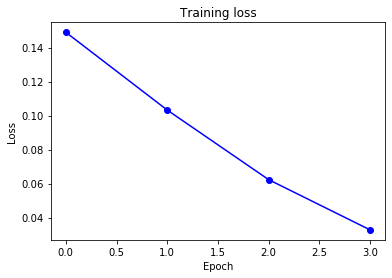

In [38]:
# Plot the learning curve.
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Performance On Test Set

* Need to apply all of the same steps that we did for the training data to prepare our test data set.

In [39]:
%%time
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sen in tqdm_notebook(test_comments.comment):
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Truncate all sentences.                        
                   )
    
    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

print('Completed\n')
print('{:>10,} test comments'.format(len(test_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = test_comments.attack.to_numpy().astype(int)

print('{:>10,} positive (contains attack)'.format(np.sum(test_labels)))
print('{:>10,} negative (not an attack)'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                               dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask) 

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


Completed

    23,178 test comments
     2,756 positive (contains attack)
    20,422 negative (not an attack)
Wall time: 1min 9s


## Test Set Predictions
With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [40]:
%%time
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()
predictions , true_labels = [], []
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # Unpack the inputs from our dataloader
    
    # =================================================================== #
    # Important dtype fix
    
    b_input_ids = batch[0].type(torch.LongTensor).to(device)
    b_input_mask = batch[1].type(torch.LongTensor).to(device)
    b_labels = batch[2].type(torch.LongTensor).to(device)
    
    # =================================================================== #
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 23,178 test sentences...
  Batch   100  of    725.    Elapsed: 0:00:17.
  Batch   200  of    725.    Elapsed: 0:00:34.
  Batch   300  of    725.    Elapsed: 0:00:50.
  Batch   400  of    725.    Elapsed: 0:01:07.
  Batch   500  of    725.    Elapsed: 0:01:24.
  Batch   600  of    725.    Elapsed: 0:01:41.
  Batch   700  of    725.    Elapsed: 0:01:57.
    DONE.
Wall time: 2min 1s


In [41]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

### Test Predictions Dataframe

`pred_0` describes confidence for `label 0` (no attack)  
`pred_1` describes confidence for `label 1` (attack)

In [42]:
dx = test_comments[['comment', 'split', 'attack']].copy()
dx['true_labels'] = true_labels
dx['pred_0'] = predictions[:,0]
dx['pred_1'] = predictions[:,1]
dx.head()

,comment,split,attack,true_labels,pred_0,pred_1
rev_id,,,,,,
155243,:If I may butt in I've spent the last 1/4 h...,test,False,0,4.752994,-5.579343
177310,On my you will find the apology that I owe...,test,False,0,4.772177,-5.604023
286174,"Yep, that's Twin cities from which this ar...",test,False,0,4.830180,-5.632815
317177,See? I was right! ;-),test,False,0,5.010329,-5.577293
386473,` Thanks for fixing the spelling error in `...,test,False,0,4.954682,-5.734451


## Prediction Verification: `False Positives`

Filtering test dataset for `non-attacks`, then sort observations by the highest `attack` prediction.

In [43]:
fp = dx[dx.attack == False].sort_values('pred_1', ascending=False)
fp.head()

,comment,split,attack,true_labels,pred_0,pred_1
rev_id,,,,,,
512598819,` == Yo there! == You are a useless and fuck...,test,False,0,-4.012422,5.013933
45024750,"== Cause of Death == Fuck exicution, put do...",test,False,0,-3.670353,4.718143
74200889,==Ban this vandal== http://en.wikipedia.org/...,test,False,0,-3.302920,4.352600
526607334,== WIDR'S P3N15 == TWO WORDS SMALL AS F***,test,False,0,-2.973959,3.902310
236375231,"== Epic == I just watched this guy on TED, ...",test,False,0,-2.951643,3.848742


In [44]:
for i in range(3):
    print('False Positive:', i, '\n', fp.comment.values[i][:300], '\n')

False Positive: 0 
 `  == Yo there! ==  You are a useless and fucking douchebag. Go fuck yourself, you are a disgrace to wikipedia!!!!  YOU, SIR, ARE A BALLSACK!  You think you are so much smarter than everyone else!  Why do you think you are so smart!  I wish you would leave the Wikipedia!  I can't stand the way you B 

False Positive: 1 
   == Cause of Death ==  Fuck exicution, put down Murder was the mutha fuckin' case, and Shawtnegger was tha murdera! 

False Positive: 2 
   ==Ban this vandal== http://en.wikipedia.org/wiki/User:Damirux  he's an idiot Tesla was a serb.  Fucking idiot 



This reveals that a lot the false-positives are actually incorrectly labeled, and the model is predicting them as it is supposed to.

## Prediction Verification: `False Negatives`
Text which is labelled as `attack`, but the model predicts as `safe`

In [45]:
fn = dx[dx.attack == True].sort_values('pred_0', ascending=False)
fn.head()

,comment,split,attack,true_labels,pred_0,pred_1
rev_id,,,,,,
436005411,`:::It is not the ``same thing``. Matters such...,test,True,1,5.072883,-5.736038
200525542,":::Eleemosynary, you're clearly a biased edi...",test,True,1,4.992578,-5.752837
422886195,== I'm watching you. == Your blatant POV pu...,test,True,1,4.989658,-5.754897
67084641,== You only want what YOU feel is important ...,test,True,1,4.980530,-5.713172
662789878,"== ) == Look, another good little Marxist.",test,True,1,4.977177,-5.637511


In [46]:
for i in range(4):
    print('Flase Negative:', i, '\n', fn.comment.values[i][:1000], '\n')

Flase Negative: 0 
 `:::It is not the ``same thing``. Matters such as this need to be open and transparent. In such cases, the user in question is notified that there is an ongoing discussion, so that he/she can participate. It is posted at some public forum like WP:ANI or Wikiquette Alerts so that the rest of the community can monitor the discussion in the interest of transparency, and so that members may participate if they choose. If a block is imposed, a template notice is placed on the user's talk page so that he/she can appeal if he/she chooses.   :::'None of this was done in this case.   :::This is completely inappropriate, and you think you're getting away with this, you're mistaken.     ` 

Flase Negative: 1 
   :::Eleemosynary, you're clearly a biased editor.  Let's face it, you lost and hopefully you'll be exiled from editing the article. 

Flase Negative: 2 
   == I'm watching you. ==  Your blatant POV pushing hasn't gone unnoticed.    

Flase Negative: 3 
   == You only wa

These are the difficult edge cases which the model incorrectly predicts as `non-attacks`.

___

The accuracy metric chosen by the authors for this dataset is the "ROC AUC" (Receiver Operating Characteristic, Area Under the Curve) rather than straight accuracy (number right / total examples).

*ROC AUC*

To illustrate the purpose of this metric, let's say that you were going to deploy this comment classifier on your website to automatically flag bad comments. In order to do that, you would have to make a decision about how confident you needed the classifier to be before flagging a comment as a personal attack.
* If it was critical that no bad comments be missed, then you might choose to set a fairly low threshold, and then have a human review what the classifier flags. This would help ensure that bad comments would be caught, but at the cost of getting more false positives that the moderator would have to deal with.
* If it wasn't critical to catch them all, and you wanted as few as possible to manually review, then you might you set a higher threshold so that you don't have as many flagged comments to review (at the risk of missing some attacks). 

The ROC AUC takes into account the fact that you can adjust the threshold to trade off false positives and false negatives, and yields a score which tries to capture overall accuracy independent of where you choose to put that threshold.

In [47]:
%%time
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# Use the model output for label 1 as our predictions.
p1 = predictions[:,1]

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.969
Wall time: 41 ms


This is a great score!

The baseline performance from the [original notebook](https://github.com/ewulczyn/wiki-detox/blob/master/src/figshare/Wikipedia%20Talk%20Data%20-%20Getting%20Started.ipynb) using tf-idf + Logistic Regression is 0.957.

In a previous experiment (in my [word2vec course](https://www.chrismccormick.ai/word2vec-the-course)), I trained a word2vec model on this dataset and then used it as the embeddings for an LSTM classifier. That approach achieved a score of 0.966. 

We've beaten both with minimal effort using BERT!

## 6. Save Trained Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [48]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

## Load Model From Saved State 

In [49]:
%%time
from transformers import BertForSequenceClassification, BertTokenizer

# The name of the folder containing the model files.
output_dir = './model_save/'

# Load our fine-tuned model, and configure it to return the "hidden states", 
# from which we will be taking our text embeddings.
model = BertForSequenceClassification.from_pretrained(
    output_dir,
    output_hidden_states = True) # Whether the model returns all hidden-states.

# Load the tokenizer.
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

Wall time: 8.82 s


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Text to Embedding function

Here we'll define a function which can take an arbitrary piece of text and use our fine-tuned BERT model to compute a feature vector (aka "embedding") for the text.

Again, we'll be using the 768-feature vector corresponding to the special `[CLS]` token, taken from the final transformer layer.

Note that, for converting large amounts of text, we could improve our performance by modifying this function to accept multiple input texts at once. GPUs (and CPUs) are most efficient when they are given a *batch* of inputs to work on.

In [50]:
import torch
from keras.preprocessing.sequence import pad_sequences

def text_to_embedding(tokenizer, model, in_text):
    '''
    Uses the provided BERT `model` and `tokenizer` to generate a vector 
    representation of the input string, `in_text`.

    Returns the vector stored as a numpy ndarray.
    '''

    # ===========================
    #    STEP 1: Tokenization
    # ===========================

    MAX_LEN = 128

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Truncate the sentence to MAX_LEN if necessary.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end. (After truncating!)
    #   (4) Map tokens to their IDs.
    input_ids = tokenizer.encode(
                        in_text,                    # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.                        
                   )    

    # Pad our input tokens. Truncation was handled above by the `encode`
    # function, which also makes sure that the `[SEP]` token is placed at the
    # end *after* truncating.
    # Note: `pad_sequences` expects a list of lists, but we only have one
    # piece of text, so we surround `input_ids` with an extra set of brackets.
    results = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", 
                              truncating="post", padding="post")
    
    # Remove the outer list.
    input_ids = results[0]

    # Create attention masks    
    attn_mask = [int(i>0) for i in input_ids]
    
    
    # Cast to tensors.
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the "batch" (even though there is only one 
    # input in this batch.)
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    # ===========================
    #    STEP 2: BERT Model
    # ===========================

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Copy the inputs to the GPU
    
    # Important include torch.LongTensor dtype fix
    # =================================================================== #
    input_ids = input_ids.type(torch.LongTensor).to(device)
    attn_mask = attn_mask.type(torch.LongTensor).to(device)
    # =================================================================== #
    
    # Telling the model not to build the backwards graph will make this 
    # a little quicker.
    with torch.no_grad():        

        # Forward pass, return hidden states and predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        logits, encoded_layers = model(
                                    input_ids = input_ids, 
                                    token_type_ids = None, 
                                    attention_mask = attn_mask)
        
    # Retrieve our sentence embedding--take the `[CLS]` embedding from the final
    # layer.
    layer_i = 12 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]
        
    # Grab the embedding.
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to the CPU and convert to numpy ndarray.
    vec = vec.detach().cpu().numpy()

    return(vec)


Using TensorFlow backend.


### Vectorize Dataset

We'll go back to the original dataset here. It should still be in memory as a pandas dataframe named `comments`.

Let's start by vectorizing a single comment.

In [51]:
# Get the text from one of the comments.
input_text = comments.iloc[10].comment

# Use `textwrap` to print the sentence nicely.
wrapper = textwrap.TextWrapper(initial_indent="    ", subsequent_indent="    ", 
                               width = 80)

print('Getting embedding for sentence:\n\n', wrapper.fill(input_text))

# Use the BERT model and tokenizer to generate an embedding for `input_text`.
vec = text_to_embedding(tokenizer, model, input_text)

print('\nDone. Embedding shape:', str(vec.shape))

Getting embedding for sentence:

       :Correct. Full biographical details will put down his birth details, etc.
    It is just a marker to me at the moment to detail the WR aspect. He
    certainly wasn't Belarus; as a geo-political entity it had no real existence
    at the time. I have put a tbc marker on this article for now.

Done. Embedding shape: (768,)


In order to perform similarity search against this comments dataset, we now need to vectorize *all* of the comments.

In [52]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Loop over all of the comments in the dataset, converting each one. Prints progress periodically. This took just under 1 hour for me to run in Colab with a T4 GPU.

In [53]:
%%time
t0 = time.time()

# Store the set of embeddings.
embeddings = []
num_comments = len(comments)
print('Generating sentence embeddings for all {:,} comments...'.format(num_comments))

row_num = 0

# For each row of the dataframe...
for index, row in comments.iterrows():

    # Progress update every 2,000 comments.
    if row_num % 2000 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_comments - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Comment {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(row_num, num_comments, elapsed, remaining))

    # Vectorize this comment.
    vec = text_to_embedding(tokenizer, model, row.comment)

    # Store the embeddings.
    embeddings.append(vec) 

    row_num += 1


Generating sentence embeddings for all 115,864 comments...
  Comment   2,000  of  115,864.    Elapsed: 0:02:03. Remaining: 1:57:01
  Comment   4,000  of  115,864.    Elapsed: 0:04:08. Remaining: 1:55:26
  Comment   6,000  of  115,864.    Elapsed: 0:06:13. Remaining: 1:53:49
  Comment   8,000  of  115,864.    Elapsed: 0:08:16. Remaining: 1:51:31
  Comment  10,000  of  115,864.    Elapsed: 0:10:19. Remaining: 1:49:11
  Comment  12,000  of  115,864.    Elapsed: 0:12:25. Remaining: 1:47:24
  Comment  14,000  of  115,864.    Elapsed: 0:14:29. Remaining: 1:45:20
  Comment  16,000  of  115,864.    Elapsed: 0:16:32. Remaining: 1:43:08
  Comment  18,000  of  115,864.    Elapsed: 0:18:35. Remaining: 1:41:05
  Comment  20,000  of  115,864.    Elapsed: 0:20:38. Remaining: 1:38:54
  Comment  22,000  of  115,864.    Elapsed: 0:22:40. Remaining: 1:36:41
  Comment  24,000  of  115,864.    Elapsed: 0:24:42. Remaining: 1:34:33
  Comment  26,000  of  115,864.    Elapsed: 0:26:44. Remaining: 1:32:25
  Com

Since creating those embeddings was such a lengthy process, let's be sure to save the embeddings to disk in case we want to reload them another time.

In [54]:
# Convert the list of vectors into a 2D array.
vecs = np.stack(embeddings)
print('vector shape:', vecs.shape)

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Use numpy to write out the matrix of embeddings.
print("Saving embeddings to: ./model_save/embeddings.npy")
np.save('./model_save/embeddings.npy', vecs)


vector shape: (115864, 768)
Saving embeddings to: ./model_save/embeddings.npy


## Semantic Similarity Search

Now that we have our comments all vectorized, we are ready to make them "searchable".

We do this using a technique called "k-Nearest Neighbor Search" or "k-NN". Simply put, we use a distance metric such as Euclidean distance, calculate that distance between our "query" vector and all of the vectors to be searched, then sort the distances to find the closest matches.

All of those distance calculations can make k-NN search computationally expensive and slow. There are a number of libraries out there for accelerating k-NN using carefully optimized code and / or approximation techniques.

I personally like the FAISS (Facebook AI Similarity Search) library, in part because it has a really excellent GPU implementation.

Using the GPU, we can perform "brute-force" k-NN search (meaning no approximation techniques which compromise on accuracy) on this dataset quickly.

### 8.1. k-NN with FAISS and GPU

To create a GPU index with FAISS, you first create it on the CPU, then copy it over.

Note: Following is for unix only (faiss-cpu is not supported on windows)

In [ ]:
!pip install faiss-cpu

In [ ]:
!pip install faiss-gpu

In [ ]:
%%time
import faiss

# =====================================
#            FAISS Setup
# =====================================

# Build a flat (CPU) index
cpu_index = faiss.IndexFlatL2(vecs.shape[1])

# Use 1 GPU.
n_gpu = 1

# Print the number of available GPUs. 
print('Number of available GPUs: %d    Using: %d' % (faiss.get_num_gpus(), n_gpu))

# If using multiple GPUs, enable sharding so that the dataset is divided across 
# the GPUs rather than replicated.
co = faiss.GpuMultipleClonerOptions()
co.shard = True

# Make it into a gpu index
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index, co=co, ngpu=n_gpu)

# Add vecs to our GPU index
print('Adding dataset to index...')
t0 = time.time()    

gpu_index.add(vecs)

elapsed = time.time() - t0
print('Building index took %.2f seconds' % (elapsed))


Now let's try taking one of the comments from the dataset, and searching for the most semantically similar comments.

In [ ]:
# Comment number 4 is short and sweet.
print('==== Input Comment =====')
print('Comment #4:')
print(wrapper.fill(comments.iloc[4].comment))

# Let's find the 5 most similar comments.
D, I = gpu_index.search(vecs[4].reshape(1, 768), k=5) 

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')

Using our `text_to_embedding` function, we can also define new text to use as our query. Let's try writing a new sentence that's similar in meaning to comment #4, but uses different language. The word "disambiguate" means "remove uncertainty of meaning from", so I've written "The meaning of this page needs to be clarified."



In [ ]:
query_text = "The meaning of this page needs to be clarified."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = gpu_index.search(query_vec.reshape(1, 768), k=5) 

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')


In [ ]:
query_text = "This article really needs more citations."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = gpu_index.search(query_vec.reshape(1, 768), k=5) 

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')


Acknowledgements:
* Chris McCormick  
`BERT Document Classification` https://www.youtube.com/watch?v=_eSGWNqKeeY